In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### Create the training data for use with the neural network. We must also save the affine scaling parameters.

In [2]:
from Chempy.parameter import ModelParameters

In [3]:
a = ModelParameters()

# Define training size
N = 8.  # 6 grid points per parameter
#widths = a.training_widths # Gaussian training widths for parameters
widths = [0.3, 0.3, 0.3, 0.1, 0.1]

In [4]:
# Make array for log time
time_array = np.linspace(0.5,2.5,int(N)) # make array wider than observed time dataset

In [89]:
from scipy.stats import norm as gaussian
prob = np.linspace(1/(N+1), 1-1/(N+1), int(N))
grids = [gaussian.ppf(prob) for _ in range(len(a.p0))] # Normalize to unit Gaussian
grids.append(time_array) ## add time array to this grid
norm_grid = np.array(np.meshgrid(*grids)).T.reshape(-1,len(a.p0)+1)

In [90]:
# Create grid in parameter space
full_widths = list(widths)+[1.]
means = list(a.p0)+[0.]
param_grid = [np.asarray(item)*full_widths+means for item in norm_grid]

**Save the two grids to file:**

- ```norm_grid``` is an array of $N^6$ sets of 6d parameter vectors.
- NB: The first five parameters are **normalized**: to get true values multiply by the width and add the mean value.
- The time parameter is **not** normalized (since it is not drawn froma  Gaussian here)


- ```Param_grid``` is of the same form but with the full grid of parameters (with no normalization applied)
- Each element is of the form $(\Theta_1,\Theta_2,\Lambda_1,\Lambda_2,\Lambda_3,T)$ 


- ```means``` gives the prior means for the parameters (for reconstruction from the normalized parameters)
- ```full_widths``` gives the scaling widths to multiply the normalized parameters by to get the true parameters.

NB: we include a 0 mean and 1. width for the time parameter so we can always write true_parameter = norm_parameter x width + means

## Load and play with training data

In [2]:
%pylab inline
training_dat = np.load('APOGEE_Training_Predictions.npz')
trainY=training_dat['abundances']
trainX=training_dat['norm_params']

Populating the interactive namespace from numpy and matplotlib


In [18]:
neurons = 20
learning_rate=0.01
epochs=500

In [40]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F

n_train = len(trainY)

# Calculate the model dimensions
dim_in = trainX.shape[1]
dim_out = trainY.shape[1]

# Convert to torch variables
tr_input = Variable(torch.from_numpy(trainX)).type(torch.FloatTensor)
tr_output = Variable(torch.from_numpy(trainY), requires_grad=False).type(torch.FloatTensor)

In [55]:
def train_neural_network(model,epochs = 600,learning_rate = 0.01):
    loss_fn = torch.nn.L1Loss(size_average=True)

    # Use Adam optimizer with learning rate specified in parameter.py
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    
    # For loss records
    losslog = []
    epoch = []
    
    # Train neural network
    for i in range(epochs):
        pred_output = model(tr_input)
        loss = loss_fn(pred_output, tr_output)
        optimizer.zero_grad() # Initially zero gradient
        loss.backward() # Backpropagation
        optimizer.step() # Update via optimizer
        scheduler.step(loss) # Update learning rate

        if i % 3 ==0:
            losslog.append(loss.data[0])
            epoch.append(i)
        if i % 100==0:
            print("Training epoch %d of %d complete" %(i,epochs))
    
    # Convert weights to numpy arrays
    model_numpy = []
    for param in model.parameters():
        model_numpy.append(param.data.numpy())

    np.savez("neural_model.npz",
                w_array_0=model_numpy[0],
                b_array_0=model_numpy[1],
                w_array_1=model_numpy[2],
                b_array_1=model_numpy[3])
    
    print("L1 Loss value is {}".format(losslog[-1]))
    
    plt.plot(epoch,losslog,label=learning_rate)
    plt.ylabel("L1 Loss value")
    plt.xlabel("Epoch")
    plt.title("Loss plot")
    plt.legend()
    plt.show()
    
    
    return model

/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Training epoch 0 of 600 complete
Training epoch 100 of 600 complete
Training epoch 200 of 600 complete
Training epoch 300 of 600 complete
Training epoch 400 of 600 complete
Training epoch 500 of 600 complete
L1 Loss value is 0.0056480346247553825


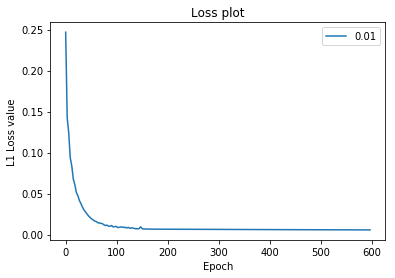

In [86]:
hidden_layer_1, hidden_layer_2 = 20, 40

model1 = torch.nn.Sequential(
    torch.nn.Linear(dim_in,hidden_layer_1),
    torch.nn.ReLU6(),
    torch.nn.Linear(hidden_layer_1,hidden_layer_2),
    torch.nn.ReLU6(),
    torch.nn.Linear(hidden_layer_2,dim_out)
    )

model1_trained = train_neural_network(model1)

/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Training epoch 0 of 600 complete
Training epoch 100 of 600 complete
Training epoch 200 of 600 complete
Training epoch 300 of 600 complete
Training epoch 400 of 600 complete
Training epoch 500 of 600 complete
L1 Loss value is 0.016459640115499496


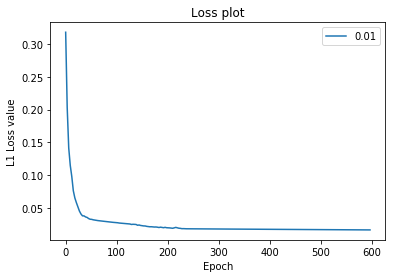

In [70]:
model2 = torch.nn.Sequential(
    torch.nn.Linear(dim_in,20),
    torch.nn.Tanh(),
    torch.nn.Linear(20,dim_out)
    )

model2_trained = train_neural_network(model2)

In [77]:
def train_neural_network_with_SGD(model,epochs = 1000,learning_rate = 0.1):
    loss_fn = torch.nn.L1Loss(size_average=True)

    # Use Adam optimizer with learning rate specified in parameter.py
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    
    # For loss records
    losslog = []
    epoch = []
    
    # Train neural network
    for i in range(epochs):
        pred_output = model(tr_input)
        loss = loss_fn(pred_output, tr_output)
        optimizer.zero_grad() # Initially zero gradient
        loss.backward() # Backpropagation
        optimizer.step() # Update via optimizer
        scheduler.step(loss) # Update learning rate

        if i % 3 ==0:
            losslog.append(loss.data[0])
            epoch.append(i)
        if i % 100==0:
            print("Training epoch %d of %d complete" %(i,epochs))
    
    # Convert weights to numpy arrays
    model_numpy = []
    for param in model.parameters():
        model_numpy.append(param.data.numpy())

    np.savez("neural_model.npz",
                w_array_0=model_numpy[0],
                b_array_0=model_numpy[1],
                w_array_1=model_numpy[2],
                b_array_1=model_numpy[3])
    
    print("L1 Loss value is {}".format(losslog[-1]))
    
    plt.plot(epoch,losslog,label=learning_rate)
    plt.ylabel("L1 Loss value")
    plt.xlabel("Epoch")
    plt.title("Loss plot")
    plt.legend()
    plt.show()
    
    
    return model

/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Training epoch 0 of 2000 complete
Training epoch 100 of 2000 complete
Training epoch 200 of 2000 complete
Training epoch 300 of 2000 complete
Training epoch 400 of 2000 complete
Training epoch 500 of 2000 complete
Training epoch 600 of 2000 complete
Training epoch 700 of 2000 complete
Training epoch 800 of 2000 complete
Training epoch 900 of 2000 complete
Training epoch 1000 of 2000 complete
Training epoch 1100 of 2000 complete
Training epoch 1200 of 2000 complete
Training epoch 1300 of 2000 complete
Training epoch 1400 of 2000 complete
Training epoch 1500 of 2000 complete
Training epoch 1600 of 2000 complete
Training epoch 1700 of 2000 complete
Training epoch 1800 of 2000 complete
Training epoch 1900 of 2000 complete
L1 Loss value is 0.014784536324441433


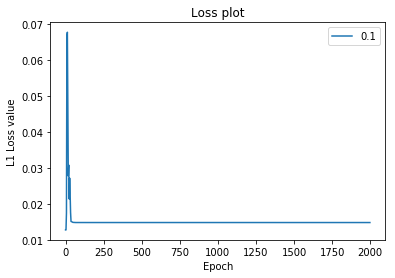

In [78]:
hidden_layer_1, hidden_layer_2 = 20,40
model3 = torch.nn.Sequential(
    torch.nn.Linear(dim_in,hidden_layer_1),
    torch.nn.ReLU6(),
    torch.nn.Linear(hidden_layer_1,hidden_layer_2),
    torch.nn.ReLU6(),
    torch.nn.Linear(hidden_layer_2,dim_out)
    )

model3_trained = train_neural_network_with_SGD(model2,epochs=2000)

In [57]:
validation_dat = np.load('TestDataset1_predictions.npz')
validationY=validation_dat['abundances']
validationX=validation_dat['norm_params']

validation_input = Variable(torch.from_numpy(validationX)).type(torch.FloatTensor)
validation_output = Variable(torch.from_numpy(validationY)).type(torch.FloatTensor)

In [58]:
validationX.shape

(9449, 6)

In [67]:
def validate_neural_network(model):
    model.eval()
    
    with torch.no_grad():
        predictedY = model(validation_input)
        loss_fn = torch.nn.L1Loss(size_average=True)
        loss = loss_fn(predictedY,validation_output)
        print("L1 Validation value for the validation set is {0}".format(loss))

In [85]:
validate_neural_network(model1_trained)
validate_neural_network(model2_trained)
validate_neural_network(model3_trained)

L1 Validation value for the validation set is 0.01138899102807045
L1 Validation value for the validation set is 0.01609194464981556
L1 Validation value for the validation set is 0.01609194464981556


/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


In [82]:
test_dat = np.load('TestDataset2_predictions.npz')
testX=validation_dat['norm_params']
testY=validation_dat['abundances']


test_input = Variable(torch.from_numpy(testX)).type(torch.FloatTensor)
test_output = Variable(torch.from_numpy(testY)).type(torch.FloatTensor)

In [83]:
def test_neural_network(model):
    model.eval()
    
    with torch.no_grad():
        predictedY = model(test_input)
        loss_fn = torch.nn.L1Loss(size_average=True)
        loss = loss_fn(predictedY,validation_output)
        print("L1 loss value for the test set is {0}".format(loss))

In [84]:
test_neural_network(model1)
test_neural_network(model2)
test_neural_network(model3)

L1 loss value for the test set is 0.01138899102807045
L1 loss value for the test set is 0.01609194464981556
L1 loss value for the test set is 0.32659363746643066


/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))
